## Forward kinematics function

In [2]:
import numpy as np
from tqdm import tqdm
import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import concurrent.futures

import random

# Link lengths (from table)
L1, L2, L3, L4, L5, L6, L7, L8, L9 = 0.055, 0.315, 0.045, 0.108, 0.005, 0.034, 0.015, 0.088, 0.204

# rotation matrix around the Z-axis
def RotZ(theta):
    return np.array([[np.cos(theta), -np.sin(theta), 0, 0],
                     [np.sin(theta),  np.cos(theta), 0, 0],
                     [0,              0,             1, 0],
                     [0,              0,             0, 1]])


def rotY(theta):
    return np.array([[np.cos(theta), 0, np.sin(theta), 0],
                     [0, 1, 0, 0],
                     [-np.sin(theta), 0, np.cos(theta), 0],
                     [0, 0, 0, 1]])



def RotX(theta):
    return np.array([[1, 0, 0, 0],
                     [0, np.cos(theta), -np.sin(theta), 0],
                     [0, np.sin(theta),  np.cos(theta), 0],
                     [0, 0, 0, 1]])

# translation matrix
def translation_matrix(tx, ty, tz):
    return np.array([[1, 0, 0, tx],
                     [0, 1, 0, ty],
                     [0, 0, 1, tz],
                     [0, 0, 0, 1]])





def forward_kinematics(theta1, theta2, theta3):
    theta1, theta2, theta3 = np.radians([theta1, theta2, theta3])
    #print("helllo")
    # Base position
    x0, y0, z0 = 0, 0, L1
    base_position = np.array([x0, y0, z0, 1])

    # Transformation matrix from frame 0 to frame 1 (shoulder)
    T1_translation = translation_matrix(L6, -L4, (L2 + L3))
   
    T1 =  RotZ(theta1) @ T1_translation  @ RotX(np.pi / 2)  # Rotation around Z and X axes
    shoulder_position = T1 @ base_position

    # Transformation matrix from frame 1 to frame 2 (elbow)
    T2_translation = translation_matrix(L7, -L8, -L5)
    T2 = RotZ(theta2) @ T2_translation
    elbow_position = T1 @ T2 @ base_position

    # Transformation matrix from frame 2 to frame 3 (hand)
    T3_translation = translation_matrix(0, -L9, 0)
    T3 = RotZ(theta3) @ T3_translation
    wrist_position = T1 @ T2 @ T3 @ base_position

    # Extract joint positions (shoulder, elbow, wrist) for 3D plotting
    # Extract joint positions (shoulder, elbow, wrist) and adjust Z-coordinates by L1
    shoulder = shoulder_position[:3] + np.array([0, 0, L1])  # Correct Z-height
    elbow = elbow_position[:3] + np.array([0, 0, L1])        # Correct Z-height
    P_end_effector = wrist_position[:3] + np.array([0, 0, L1])        # Correct Z-height

    
    return P_end_effector


## Evolutionary functions 

### 1. Fitness, 
### 2. Tournament selection,
### 3. Two point crossover,
### 4. Mutation

In [4]:
def fitness_function(x_target, y_target, z_target, theta1, theta2, theta3):
    # Calculate predicted end-effector position from forward kinematics
    P_predicted = forward_kinematics(theta1, theta2, theta3)
    P_target = np.array([x_target, y_target, z_target])
    
    # Compute the Euclidean distance (error)
    error = np.linalg.norm(P_target - P_predicted)
    
    return error


def tournament_selection(population, fitness_scores, tournament_size, tournament_prob):
    selected = []
    
    for _ in range(len(population)):
        # Sample 'tournament_size' individuals randomly
        tournament = random.sample(list(zip(population, fitness_scores)), tournament_size)
        
        # Sort the tournament participants by fitness (lower fitness is better)
        tournament = sorted(tournament, key=lambda t: t[1])
        
        # Use the tournament_prob to select the winner
        for i in range(tournament_size):
            if random.random() < tournament_prob:
                selected.append(tournament[i][0])  # Select the ith individual with probability tournament_prob
                break
        # If no one was selected due to probabilities (unlikely), select the best by default
        if len(selected) < _ + 1:
            selected.append(tournament[0][0])  # Add the best individual by default if no one was selected
    
    return selected

def two_point_crossover(individual1, individual2, chromosome_min, chromosome_max):
    """ Perform two-point crossover between two chromosomes, limiting the result to maxChromosomeLength. """
    
    # Get the lengths of the parent chromosomes (individuals)
    numInst1 = len(individual1.instructions)
    numInst2 = len(individual2.instructions)
    
    # Select two random crossover points for individual1
    cross1 =  random.randint(0, numInst1)  # Step in blocks of 4
    cross2 =  random.randint(0, numInst1)
    crossOverPoint11 = min(cross1, cross2)
    crossOverPoint12 = max(cross1, cross2)

    # Select two random crossover points for individual2
    cross1 = random.randint(0, numInst2)
    cross2 = random.randint(0, numInst2)
    crossOverPoint21 = min(cross1, cross2)
    crossOverPoint22 = max(cross1, cross2)

    # Create new individuals based on the selected crossover points
    newIndividual1_instructions = (
        individual1.instructions[:crossOverPoint11] + 
        individual2.instructions[crossOverPoint21:crossOverPoint22] + 
        individual1.instructions[crossOverPoint12:]
    )
    
    newIndividual2_instructions = (
        individual2.instructions[:crossOverPoint21] + 
        individual1.instructions[crossOverPoint11:crossOverPoint12] + 
        individual2.instructions[crossOverPoint22:]
    )

    # Limit the length of the new individuals to the maxChromosomeLength
    maxInsLength = math.floor(chromosome_max/4)
    if len(newIndividual1_instructions) > maxInsLength:
        newIndividual1_instructions = newIndividual1_instructions[:maxInsLength]
    if len(newIndividual2_instructions) > maxInsLength:
        newIndividual2_instructions = newIndividual2_instructions[:maxInsLength]

    # Create new Chromosome objects for the offspring
    newIndividual1 = Chromosome(
        len(individual1.registers), 
        len(individual1.constants), 
        chromosome_min, 
        chromosome_max)
    newIndividual1.instructions = newIndividual1_instructions
    
    newIndividual2 = Chromosome(
        len(individual2.registers), 
        len(individual2.constants), 
        chromosome_min, 
        chromosome_max)
    newIndividual2.instructions = newIndividual2_instructions
    
    return newIndividual1, newIndividual2


def mutation(chromosome, mutation_rate):
    for i in range(len(chromosome.instructions)):
        if random.random() < mutation_rate:
            #print(random.choice(chromosome.operators))
            operator = random.choice(chromosome.operators)
            dest_reg = random.randint(0, len(chromosome.registers) - 1)
            operand1 = random.choice(chromosome.registers + chromosome.constants)
            operand2 = random.choice(chromosome.registers + chromosome.constants)
            chromosome.instructions[i] = (operator, dest_reg, operand1, operand2)
    

## Chromosome class

In [6]:
import random

# Define the set of available operators
#OPERATORS = ['+', '-', '*', '/']  # You can extend this list

# Chromosome representation (list of instructions)
class Chromosome:
    def __init__(self, num_registers, num_constants, min_length, max_length):
        self.instructions = []
        self.length = random.randint(min_length, max_length)
        self.registers = [0] * num_registers  # Variable registers
        self.constants = [random.uniform(-0.5, 0.5) for _ in range(num_constants)]  # Constant registers
        self.operators = ['+', '-', '*', '/', 'sin', '>', 'cos', '**', 'square', 'sqrt']  # You can extend this list
        self.initialize_instructions()
    
    def initialize_instructions(self):
        for _ in range(self.length):
            operator = random.choice(self.operators)
            dest_reg = random.randint(0, len(self.registers) - 1)

            # Single operand for sin, otherwise two operands
            if operator == 'sin':
                operand1 = random.choice(self.registers + self.constants)
                operand2 = None  # Only one operand needed for sin
            else:
                operand1 = random.choice(self.registers + self.constants)
                operand2 = random.choice(self.registers + self.constants)
            
            self.instructions.append((operator, dest_reg, operand1, operand2))
    
    def evaluate(self, x, y, z):
        # Initialize the registers with inputs
        self.registers[0] = x
        self.registers[1] = y
        self.registers[2] = z
        
         # Execute each instruction
        i = 0
        while i < len(self.instructions):
            operator, dest_reg, op1, op2 = self.instructions[i]

            # Handle operators
            if operator == '+':
                self.registers[dest_reg] = op1 + op2
            elif operator == '-':
                self.registers[dest_reg] = op1 - op2
            elif operator == '*':
                self.registers[dest_reg] = op1 * op2
            elif operator == '/':
                if op2 != 0:  # Avoid division by zero
                    self.registers[dest_reg] = op1 / op2
                else:
                    self.registers[dest_reg] = op1/0.001
            elif operator == 'sin':
                self.registers[dest_reg] = math.sin(op1)  # Only op1 is used for sin
            elif operator == 'cos':
                self.registers[dest_reg] = math.cos(op1)  # Only op1 is used for sin
            elif operator == '>':
                # Conditional branching: if op1 > op2, execute the next instruction; otherwise, skip it
                if op1 > op2:
                    i += 1  # Proceed to the next instruction normally
                else:
                    i += 2  # Skip the next instruction
                continue  # Skip the default i += 1 at the end
            elif operator == '**':
                if op2 < 8:
                    self.registers[dest_reg] = math.e ** op2  # Exponentiation
                else:
                     self.registers[dest_reg] = math.e ** 8
            elif operator == 'square':
                self.registers[dest_reg] = op1 ** 2  # Square of op1
            elif operator == 'sqrt':
                self.registers[dest_reg] = math.sqrt(abs(op1))  # Square root of op1, ensuring non-negative input


           
            i += 1  # Move to the next instruction
        
        # 
        return self.registers[0], self.registers[1], self.registers[2]




In [7]:
# Create an initial population of chromosomes
def initialize_population(pop_size, num_registers, num_constants, chromosome_min, chromosome_max):
    population = []
    for _ in range(pop_size):
        population.append(Chromosome(num_registers, num_constants, chromosome_min, chromosome_max))
    return population

# Evaluate the fitness of the population
def evaluate_population(population, training_samples):
    def evaluate_chromosome(chrom):
        total_fitness = 0
        for sample in training_samples:
            x, y, z, theta1_true, theta2_true, theta3_true = sample
            theta1_pred, theta2_pred, theta3_pred = chrom.evaluate(x, y, z)
            fitness = fitness_function(x, y, z, theta1_pred, theta2_pred, theta3_pred)
            total_fitness += fitness
        return total_fitness / len(training_samples)
    
    # Use concurrent futures for parallel evaluation
    with concurrent.futures.ThreadPoolExecutor() as executor:
        fitness_scores = list(executor.map(evaluate_chromosome, population))
    
    return fitness_scores

def evolve_population(population, training_samples, generations, chromosome_min,  chromosome_max, tournament_size, tournament_prob, mutation_rate, crossover_prob):
    fitness_over_time = []  # To store fitness scores of all chromosomes per generation
    mean_fitness_over_time = []  # To store mean fitness of each generation
    
    # Set up the progress bar for the number of generations
    progress_bar = tqdm(total=generations, desc="Evolving Generations", unit="gen")
    for generation in range(generations):
        # Evaluate the current population
        fitness_scores = evaluate_population(population, training_samples)
        fitness_over_time.append(fitness_scores)  # Track all fitness scores
        mean_fitness = np.mean(fitness_scores)  # Calculate mean fitness of the population
        mean_fitness_over_time.append(mean_fitness)

        best_individual_index = fitness_scores.index(min(fitness_scores))
        
        # Selection
        selected_population = tournament_selection(population, fitness_scores, tournament_size, tournament_prob)
        
        # Crossover
        new_population = population.copy()
        for i in range(0, len(selected_population), 2):
            parent1, parent2 = selected_population[i], selected_population[i+1]
            
              # Perform crossover based on probability
            if random.random() < crossover_prob:
                child1, child2 = two_point_crossover(parent1, parent2, chromosome_min, chromosome_max)
                new_population[i] = child1
               
                new_population[i + 1] = child2
            else:
                # No crossover, pass parents to the next generation
                new_population[i] = parent1
              
                new_population[i + 1] = parent2
        
        # Mutation
        new_population[0] = population[best_individual_index]
        for i in range(1, len(new_population)): #Skip best individual
            # Define mutation probability relative to chromosome length
            #mutation_prob = 5 / len(new_population[i].instructions)
            mutation(new_population[i], mutation_rate)  
        
        
        # Update population
        population = new_population
        
        # Calculate and print the average chromosome length for the current generation
        if generation%100 == 0:
            avg_length = np.mean([len(chrom.instructions) for chrom in population])
            print(f"Generation {generation + 1}: Average Chromosome Length = {avg_length:.2f}")

        
        # Update the progress bar after each generation
        progress_bar.set_postfix({"Best Fitness": min(fitness_scores)})  # Optional: show the best fitness in progress bar
        progress_bar.update(1)
    
    # Close the progress bar when evolution is done
    progress_bar.close()
    
    # Plot the fitness evolution
    plot_fitness_evolution(fitness_over_time, mean_fitness_over_time)
    
    return population

# Function to plot the fitness evolution over generations
def plot_fitness_evolution(fitness_over_time, mean_fitness_over_time):
    generations = len(fitness_over_time)
    plt.figure(figsize=(12, 6))

    # Plot fitness of all chromosomes in each generation
    for gen in range(generations):
        plt.scatter([gen] * len(fitness_over_time[gen]), fitness_over_time[gen], color='blue', marker = 'o', alpha=0.05, label='Fitness' if gen == 0 else "")

    # Plot mean fitness over generations
    plt.plot(range(generations), mean_fitness_over_time, color='red', label='Mean Fitness', linewidth=2)

    plt.xlabel('Generation')
    plt.ylabel('Fitness Score')
    plt.title('Fitness Evolution Over Generations')
    plt.legend()
    plt.grid(True)
    plt.show()

In [8]:
def generate_training_data(num_samples):
    training_data = []
    
    # Keep generating samples until we have enough with z < 0.01
    while len(training_data) < num_samples:
    #for i in range(20):
        # Generate random joint angles within their respective ranges
        theta1 = random.uniform(0, 180)  # θ1 ∈ [0, 180]
        theta2 = random.uniform(0, 180)  # θ2 ∈ [0, 180]
        theta3 = random.uniform(0, 90)   # θ3 ∈ [0, 90]

        # Compute the corresponding end-effector position using forward kinematics
        x, y, z = forward_kinematics(theta1, theta2, theta3)
        # Only add the sample if the z-coordinate is close enough to 0 (z < 0.01)
        #if 0.1495<z < 0.1605:  #Smallest is 0.068
        training_data.append((x, y, z, theta1, theta2, theta3))
    return training_data



Evolving Generations:   0%|▏                                      | 1/200 [00:00<02:49,  1.17gen/s, Best Fitness=0.438]

Generation 1: Average Chromosome Length = 140.46


Evolving Generations:  50%|██████████████████▋                  | 101/200 [00:52<00:48,  2.03gen/s, Best Fitness=0.267]

Generation 101: Average Chromosome Length = 40.60


Evolving Generations: 100%|█████████████████████████████████████| 200/200 [01:41<00:00,  1.97gen/s, Best Fitness=0.262]


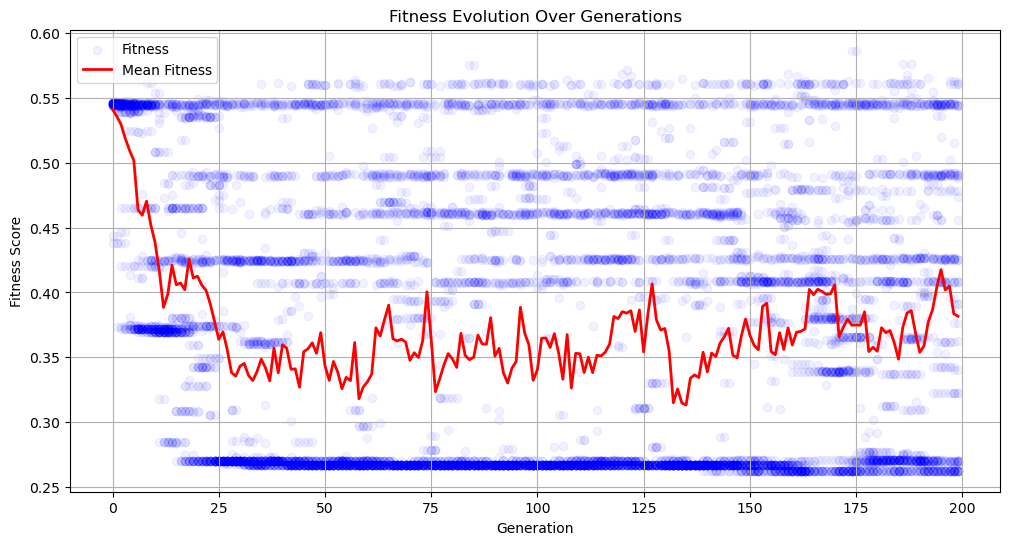

Predicted joint angles for P = (0.3, 0.15, 0.1):
Theta1: 156.7263500703055, Theta2: -18.87004093399071, Theta3: -139.3741863426664
Predicted position; [0.11376256 0.1230637  0.51634779]
Error: 0.4568976122909066


In [9]:
# Step 1: Generate Training Data
training_samples = generate_training_data(num_samples=100)

# Step 2: Initialize Population
pop_size = 50
min_chrom_length = 30
max_chrom_length = 500
tournament_size = 2
tournament_prob = 0.75
mutation_rate = 0.05
crossover_prob = 0.70
num_registers = 3
num_constants = 5
population = initialize_population(pop_size, num_registers, num_constants, min_chrom_length, max_chrom_length)

# Step 3: Evolve the Population
generations = 200
evolved_population = evolve_population(population, training_samples, generations, min_chrom_length, max_chrom_length, tournament_size, tournament_prob, mutation_rate, crossover_prob)

# Step 4: Get the Best Chromosome
best_chromosome = min(evolved_population, key=lambda chrom: evaluate_population([chrom], training_samples)[0])

# Step 5: Test the Best Chromosome
test_point = (0.3, 0.15, 0.1)
theta1_pred, theta2_pred, theta3_pred = best_chromosome.evaluate(*test_point)

# Output results
#print("Best evolved chromosome instructions:")
#for instr in best_chromosome.instructions:
 #   print(instr)

print(f"Predicted joint angles for P = {test_point}:")
print(f"Theta1: {theta1_pred}, Theta2: {theta2_pred}, Theta3: {theta3_pred}")

end_effector = forward_kinematics(theta1_pred, theta2_pred, theta3_pred)
print(f"Predicted position; {end_effector}")

print(f"Error: {fitness_function(*test_point, theta1_pred, theta2_pred, theta3_pred)}")

# Diverse code for trying to visualize the Hubert instructions. Note that this is probably not accurate and is still work in progress

In [10]:
test_point = (0.00, -0.15, 0.1)
theta1_pred, theta2_pred, theta3_pred = best_chromosome.evaluate(*test_point)

# Output results
#print("Best evolved chromosome instructions:")
#for instr in best_chromosome.instructions:
 #   print(instr)

print(f"Predicted joint angles for P = {test_point}:")
print(f"Theta1: {theta1_pred}, Theta2: {theta2_pred}, Theta3: {theta3_pred}")

end_effector = forward_kinematics(theta1_pred, theta2_pred, theta3_pred)
print(f"Predicted position; {end_effector}")

print(f"Error: {fitness_function(*test_point, theta1_pred, theta2_pred, theta3_pred)}")

Predicted joint angles for P = (0.0, -0.15, 0.1):
Theta1: 156.7263500703055, Theta2: -18.87004093399071, Theta3: -139.3741863426664
Predicted position; [0.11376256 0.1230637  0.51634779]
Error: 0.5107359255486705


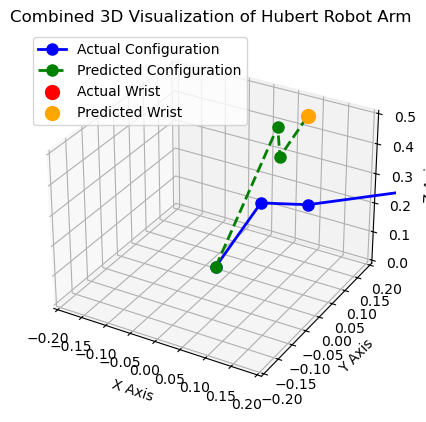

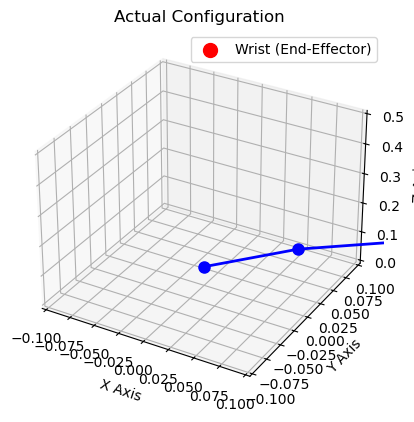

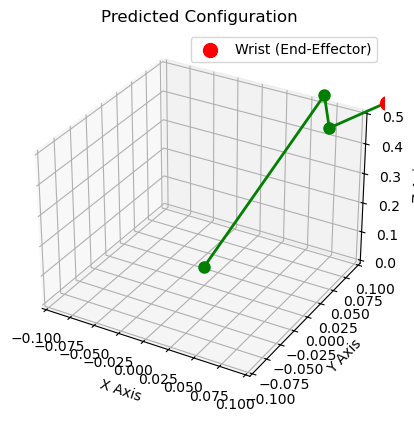

([0, 0, 0.055], array([0.0331717 , 0.16317058, 0.415     ]), array([0.0443025 , 0.15294007, 0.32687825]), array([0.11376256, 0.1230637 , 0.51634779]))
Difference:[ 0.2254438  -0.00730309 -0.13235741]


In [11]:

# Link lengths (in meters)
L1, L2, L3, L4, L5, L6, L7, L8, L9 = 0.055, 0.315, 0.045, 0.108, 0.005, 0.034, 0.015, 0.088, 0.204

def forward_kinematics_plotting(theta1, theta2, theta3):
    """ Compute the 3D coordinates of each joint and the end-effector. """
    # Convert angles from degrees to radians
    theta1, theta2, theta3 = np.radians([theta1, theta2, theta3])

    # Base position
    x0, y0, z0 = 0, 0, L1
    base_position = np.array([x0, y0, z0, 1])

    # Transformation matrix from frame 0 to frame 1 (shoulder)
    T1_translation = translation_matrix(L6, -L4, (L2 + L3))
   
    T1 =  RotZ(theta1) @ T1_translation  @ RotX(np.pi / 2)  # Rotation around Z and X axes
    shoulder_position = T1 @ base_position

    # Transformation matrix from frame 1 to frame 2 (elbow)
    T2_translation = translation_matrix(L7, -L8, -L5)
    T2 = RotZ(theta2) @ T2_translation
    elbow_position = T1 @ T2 @ base_position

    # Transformation matrix from frame 2 to frame 3 (hand)
    T3_translation = translation_matrix(0, -L9, 0)
    T3 = RotZ(theta3) @ T3_translation
    wrist_position = T1 @ T2 @ T3 @ base_position

    # Extract joint positions (shoulder, elbow, wrist) for 3D plotting
    # Extract joint positions (shoulder, elbow, wrist) and adjust Z-coordinates by L1
    shoulder = shoulder_position[:3] + np.array([0, 0, L1])  # Correct Z-height
    elbow = elbow_position[:3] + np.array([0, 0, L1])        # Correct Z-height
    wrist = wrist_position[:3] + np.array([0, 0, L1])        # Correct Z-height


    return [x0, y0, z0], shoulder, elbow, wrist  # Return all joint positions


def plot_combined_robot_arm(joint_positions_actual, joint_positions_predicted):
    """ Plot the 3D representation of the robot arm based on joint positions. """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Unpack joint positions
    base_actual, shoulder_actual, elbow_actual, wrist_actual = joint_positions_actual
    base_predicted, shoulder_predicted, elbow_predicted, wrist_predicted = joint_positions_predicted

    # Extract x, y, z coordinates for actual joints
    x_vals_actual = [base_actual[0], shoulder_actual[0], elbow_actual[0], wrist_actual[0]]
    y_vals_actual = [base_actual[1], shoulder_actual[1], elbow_actual[1], wrist_actual[1]]
    z_vals_actual = [base_actual[2], shoulder_actual[2], elbow_actual[2], wrist_actual[2]]

    # Extract x, y, z coordinates for predicted joints
    x_vals_pred = [base_predicted[0], shoulder_predicted[0], elbow_predicted[0], wrist_predicted[0]]
    y_vals_pred = [base_predicted[1], shoulder_predicted[1], elbow_predicted[1], wrist_predicted[1]]
    z_vals_pred = [base_predicted[2], shoulder_predicted[2], elbow_predicted[2], wrist_predicted[2]]
    
    # Plot actual arm links between joints
    ax.plot(x_vals_actual, y_vals_actual, z_vals_actual, marker='o', color='b', markersize=8, linewidth=2, label='Actual Configuration')
    
    # Plot predicted arm links between joints
    ax.plot(x_vals_pred, y_vals_pred, z_vals_pred, marker='o', color='g', markersize=8, linewidth=2, linestyle='--', label='Predicted Configuration')
    
    # Highlight the wrist (end-effector) positions with different colors
    ax.scatter(wrist_actual[0], wrist_actual[1], wrist_actual[2], color='r', s=100, label='Actual Wrist')
    ax.scatter(wrist_predicted[0], wrist_predicted[1], wrist_predicted[2], color='orange', s=100, label='Predicted Wrist')

    # Set plot limits and labels
    ax.set_xlim([-0.2, 0.2])
    ax.set_ylim([-0.2, 0.2])
    ax.set_zlim([0, 0.5])
    ax.set_xlabel("X Axis")
    ax.set_ylabel("Y Axis")
    ax.set_zlabel("Z Axis")
    ax.set_title("Combined 3D Visualization of Hubert Robot Arm")
    ax.legend()

    plt.show()

def plot_individual_robot_arm(joint_positions, title, color='b'):
    """ Plot the 3D representation of a single robot arm configuration. """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Unpack joint positions
    base, shoulder, elbow, wrist = joint_positions

    # Extract x, y, z coordinates for each joint
    x_vals = [base[0], shoulder[0], elbow[0], wrist[0]]
    y_vals = [base[1], shoulder[1], elbow[1], wrist[1]]
    z_vals = [base[2], shoulder[2], elbow[2], wrist[2]]
    
    # Plot arm links between joints
    ax.plot(x_vals, y_vals, z_vals, marker='o', color=color, markersize=8, linewidth=2)
    
    # Highlight the wrist (end-effector) position
    ax.scatter(wrist[0], wrist[1], wrist[2], color='r', s=100, label='Wrist (End-Effector)')

    # Set plot limits and labels
    ax.set_xlim([-0.1, 0.1])
    ax.set_ylim([-0.1, 0.1])
    ax.set_zlim([0, 0.5])
    ax.set_xlabel("X Axis")
    ax.set_ylabel("Y Axis")
    ax.set_zlabel("Z Axis")
    ax.set_title(title)
    ax.legend()

    plt.show()

# Example joint angles (in degrees)
theta1 = 45  # Base rotation
theta2 = 60  # Elbow angle
theta3 = 30  # Wrist angle

# Get the joint positions for the actual configuration
joint_positions_actual = forward_kinematics_plotting(theta1, theta2, theta3)

# Compute the actual end-effector position to use as the test point
_, _, _, wrist_actual = joint_positions_actual
actual_point = wrist_actual[:3]  # Use the end-effector position as the actual point

# Evaluate the best chromosome with the actual end-effector point
theta1_pred, theta2_pred, theta3_pred = best_chromosome.evaluate(*actual_point)

# Get joint positions using the predicted angles from the best chromosome
joint_positions_predicted = forward_kinematics_plotting(theta1_pred, theta2_pred, theta3_pred)

_, _, _, wrist_predicted = joint_positions_predicted
predicted_point = wrist_predicted[:3]
# Plot combined actual and predicted configurations
plot_combined_robot_arm(joint_positions_actual, joint_positions_predicted)

# Plot individual configurations
plot_individual_robot_arm(joint_positions_actual, title="Actual Configuration", color='b')
plot_individual_robot_arm(joint_positions_predicted, title="Predicted Configuration", color='g')

print(joint_positions_predicted)
print(f'Difference:{actual_point - predicted_point }')

[ 0.049 -0.158  0.123]
0 0


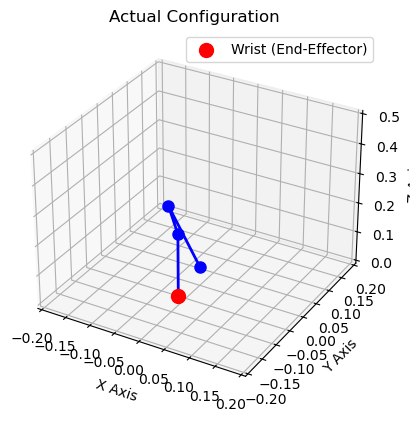

In [12]:

def plot_individual_robot_arm(joint_positions, title, color='b'):
    """ Plot the 3D representation of a single robot arm configuration. """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Unpack joint positions
    base, shoulder, elbow, wrist = joint_positions
    
    # Extract x, y, z coordinates for each joint
    x_vals = [base[0], shoulder[0], elbow[0], wrist[0]]
    y_vals = [base[1], shoulder[1], elbow[1], wrist[1]]
    z_vals = [base[2], shoulder[2], elbow[2], wrist[2]]
    print(base[0], base[0])
    # Plot arm links between joints
    ax.plot(x_vals, y_vals, z_vals, marker='o', color=color, markersize=8, linewidth=2)
    
    # Highlight the wrist (end-effector) position
    ax.scatter(wrist[0], wrist[1], wrist[2], color='r', s=100, label='Wrist (End-Effector)')

    # Set plot limits and labels
    ax.set_xlim([-0.2, 0.2])
    ax.set_ylim([-0.2, 0.2])
    ax.set_zlim([0, 0.5])
    ax.set_xlabel("X Axis")
    ax.set_ylabel("Y Axis")
    ax.set_zlabel("Z Axis")
    ax.set_title(title)
    ax.legend()

    plt.show()


# Example joint angles (in degrees)
theta1 = 0  # Base rotation
theta2 = 0  # Shoulder angle
theta3 = 0  # elbow angle

# Get the joint positions for the actual configuration
joint_positions_actual = forward_kinematics_plotting(theta1, theta2, theta3)

# Compute the actual end-effector position to use as the test point
_, _, _, wrist_actual = joint_positions_actual
print(wrist_actual)
actual_point = wrist_actual[:3]  # Use the end-effector position as the actual point
plot_individual_robot_arm(joint_positions_actual, title="Actual Configuration", color='b')